# Transformers RLHF Env

## Training Reward Model

In [1]:
from gymformer.trainer import train_reward

# There are numeruous ways to train a reward model
# The purpose is to have trained torch.nn.Module that will be called by the environment

# 1. Using our reward modeling from openai data
# Implementation of Fine-Tuning Language Models from Human Preferences (https://arxiv.org/pdf/1909.08593)
model = train_reward(
    model_name="openai-community/gpt2",
    datasets_path="../data/descriptiveness_offline_5k",
    reward_model_path="models/reward_model_new",
    test_size=0.2,
    batch_size=32,
    epochs=20,
    warmup_steps=500,
    dry_run=True
)


# 2. Using huggingface standard classification model

# from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
# tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
# model = AutoModelForSequenceClassification.from_pretrained("openai-community/gpt2", num_labels=1, problem_type='regression')
# ...
# trainer.train()

/home/ez/.cache/pypoetry/virtualenvs/finetuning-lm-from-human-preferences-4SAAosyV-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: eryaw to https://api.wandb.ai. Use `wandb lo

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Accuracy,Mrr
1,No log,2.222384,0.150000,0.487500


Saving best reward model to models/reward_model_new
Reward model saved successfully to models/reward_model_new


In [2]:
from gymformer.trainer.trainer import load_reward_model

# if using RewardModelWrapper, use this
model = load_reward_model("models/reward_model_new")
# if using AutoModelForSequenceClassification, just directly load the model
# model = AutoModelForSequenceClassification.from_pretrained("models/reward_model_new", num_labels=1, problem_type='regression')

## Training Language Model

In [3]:
from gymformer.rl.transformers_nn import LMActorNetwork, LMCriticNetwork
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
actor = LMActorNetwork(
    model_name="openai-community/gpt2",
    pad_token_id=tokenizer.eos_token_id,
)
critic = LMCriticNetwork(
    model_name="openai-community/gpt2",
    pad_token_id=tokenizer.eos_token_id,
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
from gymformer.rl.ppo import PPOConfig
from gymformer.trainer.trainer import train_agent
from gymformer.env.rlhf_env import RLHFEnv # Important! Register the environment

ppo_config = PPOConfig(
    lr_actor=3e-4,
    lr_critic=1e-3,
    gamma=0.99,
    eps_clip=0.2,
    update_epochs=10,
    minibatch_size=-1,
    pad_obs=True,
    int_obs=True,
)
callback = (
    lambda state, action, reward, done, truncated, episode, running_reward: (
        print("="*20),
        print('[STATE]:\n', tokenizer.decode(state)),
        print('[ACTION]:\n', tokenizer.decode(action)),
        print('[REWARD]:\n', reward),
        print('[DONE]:\n', done),
        print('[TRUNCATED]:\n', truncated),
        print("="*20)
    )
)
rewards_discrete = train_agent(
    env_name='RLHFEnv-v0',
    actor=actor,
    critic=critic,
    ppo_config=ppo_config,
    max_episodes=1, 
    max_timesteps=1000, 
    update_interval=5, 
    save_interval=1,
    callback=callback,
    log_interval=1
)

[STATE]:
  I wasn't the cause of her wearing them carelessly. I wasn't to blame that the thieves caught her unawares."

Diamonds? There was a lie in this. Esther had worn no diamonds. The Evals had taken from her no diamonds. That was "clean" infrastructure and was now not radioactive. Apparently complaining was both Newcastle's business because of precious metal waste and from London.

Mercury was resprising. The Newcastle baby's body started glow-in-the-dark. Soon, it was bad.

A photograph of an
[ACTION]:
  an
[REWARD]:
 1.6049648427963257
[DONE]:
 False
[TRUNCATED]:
 True
Episode 1, Running Reward: 3.20
Saved checkpoint to ./models/ppo_RLHFEnv-v0_episode_1.pth


In [23]:
from transformers import AutoTokenizer
from gymformer.trainer.trainer import load_ppo_agent

# trained_critic is no longer needed in most cases
trained_actor, trained_critic = load_ppo_agent("./models/ppo_RLHFEnv-v0_episode_1.pth", actor, critic)

# Specific task use, in RLHF we inference the actor model on text data
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
encoded = tokenizer("Hello, how are you?", return_tensors="pt").to(actor.lm_model.device)
generated = trained_actor.lm_model.generate(**encoded)
tokenizer.decode(generated[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Hello, how are you?\n\nI'm a little bit of a nerd. I'm a big nerd. I'm a"

# RLVR

In [ ]:
from gymformer.rl.transformers_nn import LMActorNetwork, LMCriticNetwork
from transformers import AutoTokenizer

MODEL_NAME = "Qwen/Qwen2-0.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
actor = LMActorNetwork(
    model_name=MODEL_NAME,
    pad_token_id=tokenizer.pad_token_id if tokenizer.pad_token_id else tokenizer.eos_token_id,
)
critic = LMCriticNetwork(
    model_name=MODEL_NAME,
    pad_token_id=tokenizer.pad_token_id if tokenizer.pad_token_id else tokenizer.eos_token_id,
)

/home/ez/.cache/pypoetry/virtualenvs/finetuning-lm-from-human-preferences-4SAAosyV-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2-0.5B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from gymformer.rl.ppo import PPOConfig
from gymformer.trainer.trainer import train_agent
from gymformer.env.rlhf_env import RLHFEnv # Important! Register the environment

ppo_config = PPOConfig(
    lr_actor=3e-4,
    lr_critic=1e-3,
    gamma=0.99,
    eps_clip=0.2,
    update_epochs=10,
    minibatch_size=-1,
    pad_obs=True,
    int_obs=True,
)
callback = (
    lambda state, action, reward, done, truncated, episode, running_reward: (
        print("="*20),
        print('[STATE]:\n', tokenizer.decode(state)),
        print('[ACTION]:\n', tokenizer.decode(action)),
        print('[REWARD]:\n', reward),
        print('[DONE]:\n', done),
        print('[TRUNCATED]:\n', truncated),
        print("="*20)
    )
)
rewards_discrete = train_agent(
    env_name='CoTEnv-v0',
    actor=actor,
    critic=critic,
    ppo_config=ppo_config,
    max_episodes=3, 
    max_timesteps=400, 
    update_interval=5, 
    save_interval=3,
    callback=callback,
    log_interval=1
)

# Classic Env

In [ ]:
from gymformer.rl.common_nn import MLPActorNetwork, MLPCriticNetwork
from gymformer.rl.ppo import PPOConfig
from gymformer.trainer.trainer import train_agent
import gymnasium as gym

env_name = 'CartPole-v1'
env = gym.make(env_name)

actor = MLPActorNetwork(
    env.observation_space.shape[0],
    64,
    env.action_space.n,
)
critic = MLPCriticNetwork(
    env.observation_space.shape[0],
    64,
)

ppo_config = PPOConfig(
    lr_actor=3e-4,
    lr_critic=1e-3,
    gamma=0.99,
    eps_clip=0.2,
    update_epochs=10,
    minibatch_size=512
)
rewards_discrete = train_agent(
    env_name=env_name,
    actor=actor,
    critic=critic,
    ppo_config=ppo_config,
    max_episodes=1000, 
    max_timesteps=1000, 
    update_interval=100, 
    save_interval=1000,
    log_interval=100
)

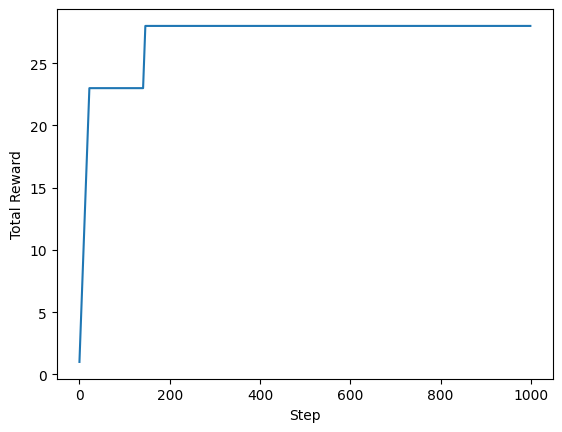

In [9]:
from gymformer.trainer.trainer import load_ppo_agent

# trained_critic is no longer needed in most cases
ppo_agent = load_ppo_agent("./models/PPO_CartPole-v1_100.pth", actor, critic)

# Specific task use, in CartPole we inference the actor model on simulation
env = gym.make(env_name)
obs, _ = env.reset()
cumm_rewards = []
cumm_reward = 0
for _ in range(1000):
    action = ppo_agent.select_action(obs)
    obs, reward, done, truncated, info = env.step(action)
    cumm_reward += reward
    cumm_rewards.append(cumm_reward)

# Visualize the reward
import matplotlib.pyplot as plt
plt.plot(cumm_rewards)
plt.xlabel("Step")
plt.ylabel("Total Reward")
plt.show()